# Preparing Azure Notebooks

I found some challenges loading the full VGG16 model and weights into Azure Notebooks directly, so we're including some commands to make sure the Azure Notebooks machine is up to date, and then we'll load up VGG16 and it's weights seperately. 

In [1]:
# Let's make sure we are using the most recent version of PIP

!python.exe -m pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\admin\envs\deepvision\lib\site-packages (10.0.1)


In [2]:
# Also, I was having some difficulty between the current version of h5py, keras and Tensorflow in this notebook,
# so let's upgrade to the most recent release candidate of h5py ( there were challenges with float32() and float64()
# in the current version...

# NOTE: This notebook / cell is being written on 4/25/2018. In the future, a more up to date version may have resolved the
# problem, so consider this specific version number timestamped for this period of time ~ May 2018

!pip install h5py==2.8.0rc1

In [3]:
# Now let's bring in the keras libraries, including their copy of the VGG16 'engine framework'

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [4]:
# Now let's make a local copy of the VGG16 model, but without weights for now! We will load these seperately next...

model = VGG16(weights=None, include_top=True)

In [5]:
# Now let's download and the weights seperately. This is a HUGE file, so Azure Notebooks at times is crashing if 
# we attempt to create the model and 'download/load' the weights in the same line of code like this:
# model = VGG16(weights='imagenet', include_top=True)
# That's why we're doing this in two parts...

from keras.utils.data_utils import get_file

EXTERNAL_WEIGHT_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                        EXTERNAL_WEIGHT_PATH,
                        cache_subdir='models')


In [6]:
model.load_weights(weights_path)

## If you've gotten this far, you're good to go!

start coding in the next cell...

In [7]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(?, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tenso

In [8]:
model.count_params()

138357544

In [9]:
import numpy as np
from PIL import Image

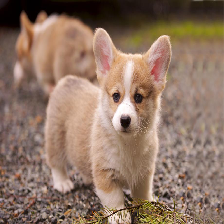

In [13]:
image_path = 'images/puppy.jpg'
image = Image.open(image_path)
image = image.resize((224, 224))
image

In [14]:
# Convert it into an array
x = np.asarray(image, dtype='float32')
# Convert it into a list of arrays
x = np.expand_dims(x, axis=0)
# Pre-process the input to match the training data
x = preprocess_input(x)


In [15]:
prediction = model.predict(x)
print("results: ", decode_predictions(prediction, top=3)[0])

results:  [('n02113023', 'Pembroke', 0.8048494), ('n02113186', 'Cardigan', 0.14236082), ('n02115641', 'dingo', 0.010540721)]


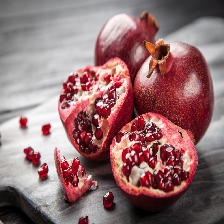

In [16]:
image_path = 'images/fruit.jpg'
image = Image.open(image_path)
image = image.resize((224, 224))
image

In [17]:
x = np.asarray(image, dtype='float32')
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
prediction = model.predict(x)
print("results: ", decode_predictions(prediction, top=3)[0])

results:  [('n07768694', 'pomegranate', 0.9996426), ('n07753113', 'fig', 0.00027274303), ('n07720875', 'bell_pepper', 2.3141958e-05)]


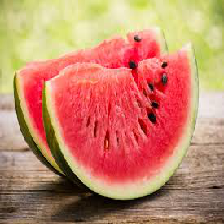

In [18]:
image_path = 'images/watermelon.jpg'
image = Image.open(image_path)
image = image.resize((224, 224))
image

In [19]:
x = np.asarray(image, dtype='float32')
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
prediction = model.predict(x)
print("results: ", decode_predictions(prediction, top=3)[0])

results:  [('n07753113', 'fig', 0.9767526), ('n07768694', 'pomegranate', 0.011820442), ('n07742313', 'Granny_Smith', 0.0042773704)]
